In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.sqrt import UnarySqrt
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time
import math
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rng = "Sobol"

In [4]:
def test(mode = "unipolar", bitwidth = 8, jk_trace = False, emit = True):
    stype = torch.float
    randtype = torch.float
    
    print("========================================================")
    print(mode)
    print("========================================================")
    # all input values are non-negative
    low_bound = 0
    if mode is "unipolar":
        up_bound = 2**bitwidth
    elif mode is "bipolar":
        low_bound = 0
        up_bound = 2**(bitwidth-1)

    input_list = []
    for input_val in range(low_bound, up_bound+1, 1):
        input_list.append(input_val)
    
    input = torch.tensor(input_list).type(torch.float).div(up_bound).to(device)

    dut_sqrt = UnarySqrt(mode=mode, 
                         jk_trace=jk_trace, 
                         depth_kernel=2, 
                         rng="Sobol", 
                         rng_dim=4, 
                         emit=emit, 
                         depth_emit=5, 
                         depth_sync=2, 
                         stype=torch.float).to(device)

    output = torch.sqrt(input).to(device)
    outputPE = ProgressiveError(output, mode=mode).to(device)
    
    inputPE  = ProgressiveError(input,  mode=mode).to(device)
    inputSRC = SourceGen(input, bitwidth, mode=mode, randtype=randtype)().to(device)
    inputRNG = RNG(bitwidth, 1, rng, randtype)().to(device)
    inputBS = BSGen(inputSRC, inputRNG, stype).to(device)
    
    with torch.no_grad():
        start_time = time.time()
        for i in range(2**bitwidth):
            input_bs = inputBS(torch.tensor([i]))
            inputPE.Monitor(input_bs)

            ouyput_bs = dut_sqrt(input_bs)
            outputPE.Monitor(ouyput_bs)
        print("--- %s seconds ---" % (time.time() - start_time))
        print("input error: ", "min:", torch.min(inputPE()[1]).item(), ", max:", torch.max(inputPE()[1]).item())
        # set invalid output statistics to special values
        print("output error:", "min:", torch.min(outputPE()[1]).item(), ", max:", torch.max(outputPE()[1]).item())
        
        #######################################################################
        # check the error distribution using histogram
        #######################################################################
        result_pe = outputPE()[1].cpu().numpy()
        result_pe = result_pe.flatten()
        print("RMSE:", math.sqrt(np.mean(result_pe**2)))
        print("MAE: ", np.mean(np.abs(result_pe)))
        print("bias:", np.mean(result_pe))
        fig = plt.hist(result_pe, bins='auto', log=False)  # arguments are passed to np.histogram
        plt.title("Histogram for final output error")
        plt.show()
        
        #######################################################################
        # check the 3D plot contourf
        #######################################################################
        result_pe = outputPE()[1].cpu().numpy()
        fig = plt.figure()
        axis_len = outputPE()[1].size()[0]
        input_x_axis = []
        for axis_index in range(axis_len):
            input_x_axis.append((axis_index/(axis_len-1)*(up_bound-low_bound)+low_bound)/up_bound)
        cs = plt.plot(input_x_axis, result_pe)
        plt.xlabel('Input value')
        plt.ylabel('Output error')
        plt.ylim(-0.35, 0.55)
        plt.show()

unipolar
--- 0.6449997425079346 seconds ---
input error:  min: -0.00390625 , max: 0.0
output error: min: -0.0830266922712326 , max: 0.1216748058795929
RMSE: 0.0569931459019471
MAE:  0.04256738
bias: 0.029617855


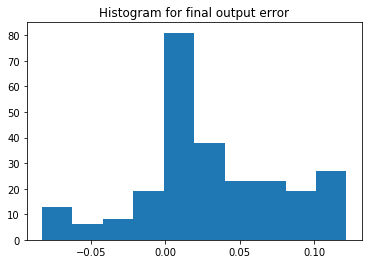

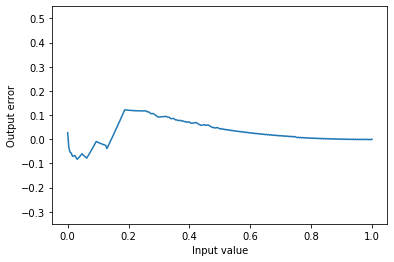

In [5]:
test(mode = "unipolar", bitwidth = 8, emit = True, jk_trace = False)

unipolar
--- 0.40599942207336426 seconds ---
input error:  min: -0.00390625 , max: 0.0
output error: min: -0.25 , max: 0.0019550323486328125
RMSE: 0.15179002829840382
MAE:  0.13707416
bias: -0.13705896


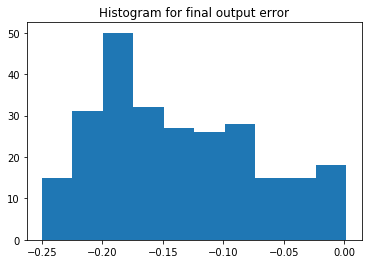

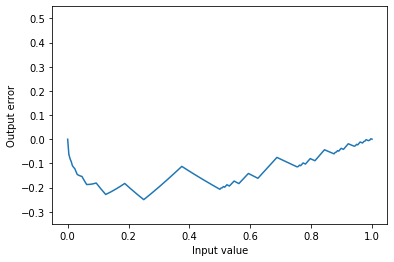

In [6]:
test(mode = "unipolar", bitwidth = 8, emit = False, jk_trace = True)

unipolar
--- 0.43599677085876465 seconds ---
input error:  min: -0.00390625 , max: 0.0
output error: min: -0.24609375 , max: 0.010047495365142822
RMSE: 0.15302867852306246
MAE:  0.124135725
bias: -0.12251311


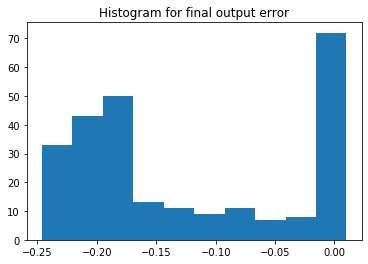

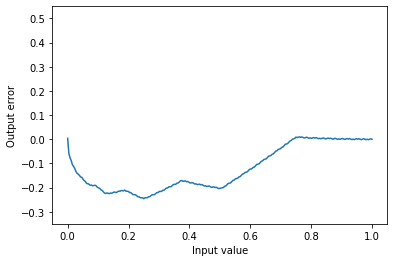

In [7]:
test(mode = "unipolar", bitwidth = 8, emit = False, jk_trace = False)

bipolar
--- 0.8520002365112305 seconds ---
input error:  min: 0.0 , max: 0.0
output error: min: -0.1484375 , max: 0.07372748851776123
RMSE: 0.06152161527387401
MAE:  0.044039205
bias: -0.0116494885


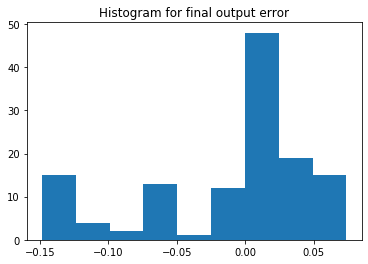

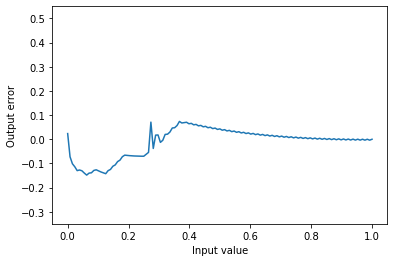

In [8]:
test(mode = "bipolar", bitwidth = 8, emit = True, jk_trace = False)

bipolar
--- 0.44499731063842773 seconds ---
input error:  min: 0.0 , max: 0.0
output error: min: -0.17045161128044128 , max: 0.04289323091506958
RMSE: 0.08205553387918448
MAE:  0.056797516
bias: -0.041203752


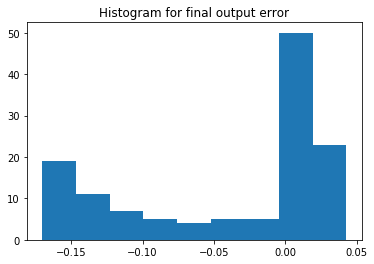

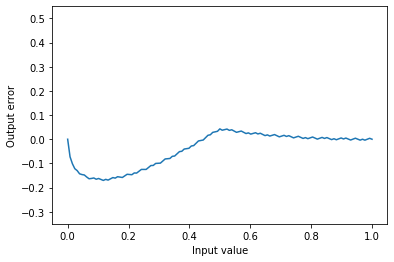

In [9]:
test(mode = "bipolar", bitwidth = 8, emit = False, jk_trace = True)

bipolar
--- 0.5439984798431396 seconds ---
input error:  min: 0.0 , max: 0.0
output error: min: -0.17045161128044128 , max: 0.04289323091506958
RMSE: 0.08205841670460073
MAE:  0.056858078
bias: -0.04114319


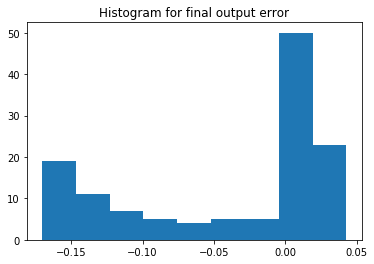

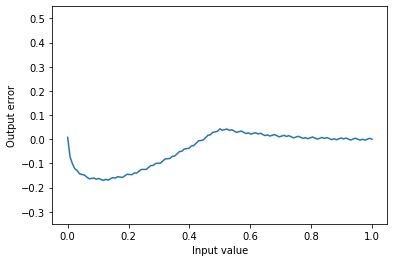

In [10]:
test(mode = "bipolar", bitwidth = 8, emit = False, jk_trace = False)